In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [21]:
def generate_sinusoidal_tvar(n=6000, p=3, noise_std=0.1, seed=42):
    """
    Generates TVAR data where coefficients evolve according to sine waves.
    Each lag coefficient phi_i(t) has its own frequency and phase.
    """
    rng = np.random.default_rng(seed)

    # 1. Define Time
    t_arr = np.arange(n)
    
    # 2. Define the Family of Functions (Sinusoids)
    # We generate random parameters for the sine waves for EACH lag (p)
    # phi_i(t) = scale * sin(freq * t + phase)
    
    # Random frequencies between 0.001 and 0.005 (slow evolution)
    freqs = rng.uniform(0.001, 0.005, size=p) / 7
    print(freqs)
    phases = rng.uniform(0, 2*np.pi, size=p)
    
    # Scale determines how strong the coefficient is.
    # kept small (0.1 to 0.3) to prevent instability
    scales = rng.uniform(0.1, 0.3, size=p) 
    
    # Initialize coefficient matrix (n, p)
    a_time = np.zeros((n, p))
    
    for i in range(p):
        # Apply the function: A * sin(wt + phi)
        # We explicitly calculate the curve for the entire duration
        a_time[:, i] = scales[i] * np.sin(2 * np.pi * freqs[i] * t_arr + phases[i])
    
    # 3. Simulation Loop (Standard AR generation)
    x = np.zeros(n)
    eps = rng.normal(0.0, noise_std, size=n)
    
    # Init first p samples
    x[:p] = eps[:p]
    
    for t in range(p, n):
        lags = x[t-p:t][::-1]
        
        # Dot product of CURRENT coefficients with past values
        x[t] = np.dot(a_time[t], lags) + eps[t]
        
        # Stability check
        if np.abs(x[t]) > 1000:
            print(f"Signal exploded at t={t}")
            break
            
    return x, a_time, t_arr

[0.00058512 0.00039364 0.00063348 0.00054135]


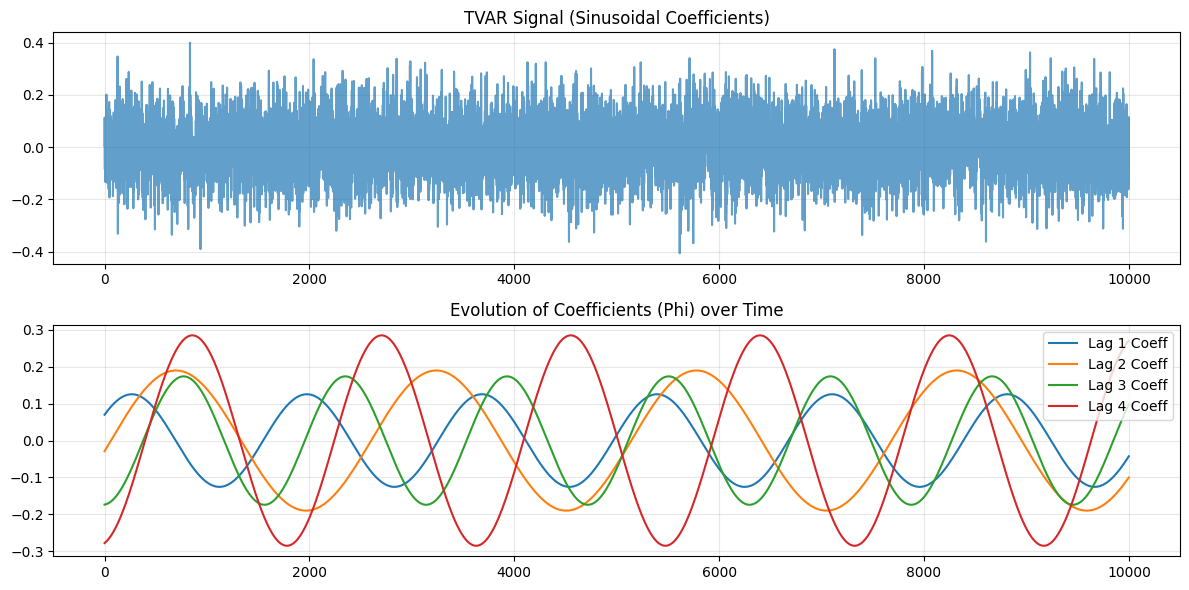

In [22]:
# Generate and Visualize TVAR Data
x, a_true, t = generate_sinusoidal_tvar(n=10000, p=4)

plt.figure(figsize=(12, 6))

# Plot 1: The Generated Signal
plt.subplot(2, 1, 1)
plt.plot(t, x, alpha=0.7)
plt.title("TVAR Signal (Sinusoidal Coefficients)")
plt.grid(True, alpha=0.3)

# Plot 2: The Underlying Coefficients (The "Hidden" Truth)
plt.subplot(2, 1, 2)
for i in range(a_true.shape[1]):
    plt.plot(t, a_true[:, i], label=f'Lag {i+1} Coeff')
plt.title("Evolution of Coefficients (Phi) over Time")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
def make_lagged_dataset(x, Pmax, include_time=False):
    x = np.asarray(x)
    T = len(x)
    X = np.stack([x[Pmax-k:T-k] for k in range(1, Pmax+1)], axis=1)  # (T-Pmax, Pmax)
    y = x[Pmax:]                                                     # (T-Pmax,)
    
    if include_time:
        # Add normalized time indices
        t_indices = np.arange(Pmax, T).astype(np.float32)
        t_normalized = t_indices / T  # Normalize to [0, 1]
        return X, y, t_normalized
    
    return X, y

In [24]:
class TransformerAR_Coeff(nn.Module):
    """
    Time-aware AR forecasting with linear coefficients:
      - Encoder processes lag tokens + time information.
      - Model outputs per-lag coefficients a_k(t) and bias b(t) that vary with time.
      - Prediction is forced to be linear in lags: yhat = sum_k a_k(t) * x_{t-k} + b(t)

    X_seq: (B, Pmax, 1) where position 0 is x_{t-1}, position 1 is x_{t-2}, ...
    t_input: (B, 1) normalized time index for each sample
    """
    def __init__(self, Pmax, d_model=64, nhead=4, depth=2, dropout=0.0, use_time=True):
        super().__init__()
        self.Pmax = Pmax
        self.d_model = d_model
        self.use_time = use_time

        # Project scalar lag token -> d_model
        self.in_proj = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
        )

        # Time embedding (if using time)
        if self.use_time:
            self.time_proj = nn.Sequential(
                nn.Linear(1, d_model),
                nn.LayerNorm(d_model),
                nn.GELU(),
            )

        # Learned positional embedding for lag index
        self.pos = nn.Parameter(torch.zeros(1, Pmax, d_model))
        nn.init.normal_(self.pos, mean=0.0, std=0.02)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)

        # Head that produces a_k per lag token
        self.coeff_head = nn.Linear(d_model, 1)

        # Bias from pooled representation (mean-pool is stable)
        self.bias_head = nn.Linear(d_model, 1)

        # Small init helps keep early predictions stable
        nn.init.normal_(self.coeff_head.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.coeff_head.bias)
        nn.init.normal_(self.bias_head.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.bias_head.bias)

    def forward(self, X_seq, t_input=None, return_coeffs=False):
        # Encode lag tokens
        h = self.in_proj(X_seq) + self.pos       # (B, P, d)
        
        # Add time information if available
        if self.use_time and t_input is not None:
            # Time embedding broadcasted to all lag positions
            t_emb = self.time_proj(t_input.unsqueeze(-1))  # (B, 1, d)
            h = h + t_emb                                   # (B, P, d)
        
        h = self.encoder(h)                      # (B, P, d)

        # Per-lag coefficients (now time-dependent)
        a = self.coeff_head(h).squeeze(-1)       # (B, P)

        # Bias from pooled rep (now time-dependent)
        b = self.bias_head(h.mean(dim=1)).squeeze(-1)  # (B,)

        # Forced AR dot product
        x = X_seq.squeeze(-1)                    # (B, P)
        yhat = (a * x).sum(dim=1) + b            # (B,)

        if return_coeffs:
            return yhat, a, b
        return yhat

In [25]:
def train_ar_transformer(
    x, Pmax,
    d_model=64, nhead=4, depth=2, dropout=0.05,
    lr=2e-3, weight_decay=1e-4,
    epochs=300, batch_size=256,
    eval_every=10, patience=30,
    use_time=True,
    seed=0, device=None,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(seed)
    np.random.seed(seed)

    X, y, t_norm = make_lagged_dataset(x, Pmax, include_time=use_time)  # X: (N, Pmax), y: (N,), t: (N,)
    N = len(y)

    # time-ordered split (60/20/20)
    n_tr = int(0.6 * N)
    n_va = int(0.2 * N)
    tr_slice = slice(0, n_tr)
    va_slice = slice(n_tr, n_tr + n_va)
    te_slice = slice(n_tr + n_va, N)

    X_tr, y_tr = X[tr_slice], y[tr_slice]
    X_va, y_va = X[va_slice], y[va_slice]
    X_te, y_te = X[te_slice], y[te_slice]
    
    if use_time:
        t_tr, t_va, t_te = t_norm[tr_slice], t_norm[va_slice], t_norm[te_slice]

    # standardize using TRAIN only (features + target)
    X_mean = X_tr.mean(axis=0, keepdims=True)
    X_std  = X_tr.std(axis=0, keepdims=True) + 1e-8
    y_mean = y_tr.mean()
    y_std  = y_tr.std() + 1e-8

    X_tr_s = (X_tr - X_mean) / X_std
    X_va_s = (X_va - X_mean) / X_std
    X_te_s = (X_te - X_mean) / X_std
    y_tr_s = (y_tr - y_mean) / y_std
    y_va_s = (y_va - y_mean) / y_std
    y_te_s = (y_te - y_mean) / y_std

    # reshape into sequences (B, Pmax, 1)
    def to_seq(a):
        return a.astype(np.float32).reshape(-1, Pmax, 1)

    X_tr_t = torch.from_numpy(to_seq(X_tr_s))
    X_va_t = torch.from_numpy(to_seq(X_va_s))
    X_te_t = torch.from_numpy(to_seq(X_te_s))
    y_tr_t = torch.from_numpy(y_tr_s.astype(np.float32))
    y_va_t = torch.from_numpy(y_va_s.astype(np.float32))
    y_te_t = torch.from_numpy(y_te_s.astype(np.float32))
    
    if use_time:
        t_tr_t = torch.from_numpy(t_tr.astype(np.float32))
        t_va_t = torch.from_numpy(t_va.astype(np.float32))
        t_te_t = torch.from_numpy(t_te.astype(np.float32))
        tr_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t, t_tr_t), batch_size=batch_size, shuffle=True, drop_last=False)
        va_loader = DataLoader(TensorDataset(X_va_t, y_va_t, t_va_t), batch_size=batch_size, shuffle=False, drop_last=False)
        te_loader = DataLoader(TensorDataset(X_te_t, y_te_t, t_te_t), batch_size=batch_size, shuffle=False, drop_last=False)
    else:
        tr_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=batch_size, shuffle=True, drop_last=False)
        va_loader = DataLoader(TensorDataset(X_va_t, y_va_t), batch_size=batch_size, shuffle=False, drop_last=False)
        te_loader = DataLoader(TensorDataset(X_te_t, y_te_t), batch_size=batch_size, shuffle=False, drop_last=False)

    model = TransformerAR_Coeff(Pmax, d_model=d_model, nhead=nhead, depth=depth, dropout=dropout, use_time=use_time).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best = {"val": float("inf"), "state": None, "epoch": -1}
    bad = 0

    @torch.no_grad()
    def eval_mse(loader):
        model.eval()
        tot, cnt = 0.0, 0
        for batch in loader:
            if use_time:
                xb, yb, tb = batch
                tb = tb.to(device)
            else:
                xb, yb = batch
                tb = None
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb, tb)
            loss = loss_fn(pred, yb)
            bs = xb.size(0)
            tot += loss.item() * bs
            cnt += bs
        return tot / max(cnt, 1)

    for ep in range(1, epochs + 1):
        model.train()
        for batch in tr_loader:
            if use_time:
                xb, yb, tb = batch
                tb = tb.to(device)
            else:
                xb, yb = batch
                tb = None
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb, tb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        if ep % eval_every == 0 or ep == 1:
            val = eval_mse(va_loader)
            if val < best["val"] - 1e-6:
                best["val"] = val
                best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                best["epoch"] = ep
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    break

    if best["state"] is not None:
        model.load_state_dict(best["state"])

    val_mse = eval_mse(va_loader)
    te_mse  = eval_mse(te_loader)

    # convenience prediction function (returns unstandardized predictions)
    @torch.no_grad()
    def predict_np(X_raw, t_raw=None):
        """
        X_raw: (N, Pmax) raw lags (unstandardized)
        t_raw: (N,) time indices (if use_time=True)
        returns yhat in original scale
        """
        Xs = (X_raw - X_mean) / X_std
        Xs = Xs.astype(np.float32).reshape(-1, Pmax, 1)
        xb = torch.from_numpy(Xs).to(device)
        
        if use_time and t_raw is not None:
            tb = torch.from_numpy(t_raw.astype(np.float32)).to(device)
        else:
            tb = None
            
        model.eval()
        yhat_s = model(xb, tb).detach().cpu().numpy()
        return yhat_s * y_std + y_mean

    scalers = {"X_mean": X_mean, "X_std": X_std, "y_mean": y_mean, "y_std": y_std}
    splits = {
        "X_tr": X_tr, "y_tr": y_tr,
        "X_va": X_va, "y_va": y_va,
        "X_te": X_te, "y_te": y_te,
    }
    
    if use_time:
        splits["t_tr"] = t_tr
        splits["t_va"] = t_va
        splits["t_te"] = t_te
    
    metrics = {"val_mse_standardized": val_mse, "test_mse_standardized": te_mse, "best_epoch": best["epoch"]}
    return model, predict_np, scalers, splits, metrics

In [26]:
def sweep_p_transformer(x, p_range, **train_kwargs):
    results = {}
    for p in p_range:
        model, predict_np, scalers, splits, metrics = train_ar_transformer(
            x, Pmax=p, **train_kwargs
        )
        results[p] = {
            "model": model,
            "predict_np": predict_np,
            "scalers": scalers,
            "splits": splits,
            "metrics": metrics,
        }
        print(f"p={p:2d} | val={metrics['val_mse_standardized']:.4f} "
              f"| test={metrics['test_mse_standardized']:.4f} "
              f"| best_ep={metrics['best_epoch']}")
    return results

In [27]:
# Sweep over different p values to find the best model order
p_range = range(1, 10)
results = sweep_p_transformer(
    x, p_range,
    d_model=64, nhead=4, depth=2, dropout=0.05,
    lr=2e-3, weight_decay=1e-4,
    epochs=300, batch_size=256,
    eval_every=10, patience=30,
    use_time=True,
    seed=0, device=None
)

best_p = min(results, key=lambda p: results[p]["metrics"]["val_mse_standardized"])
print(f"\nBest p = {best_p}")
print(f"Best model val loss = {results[best_p]['metrics']['val_mse_standardized']:.6f}")

KeyboardInterrupt: 

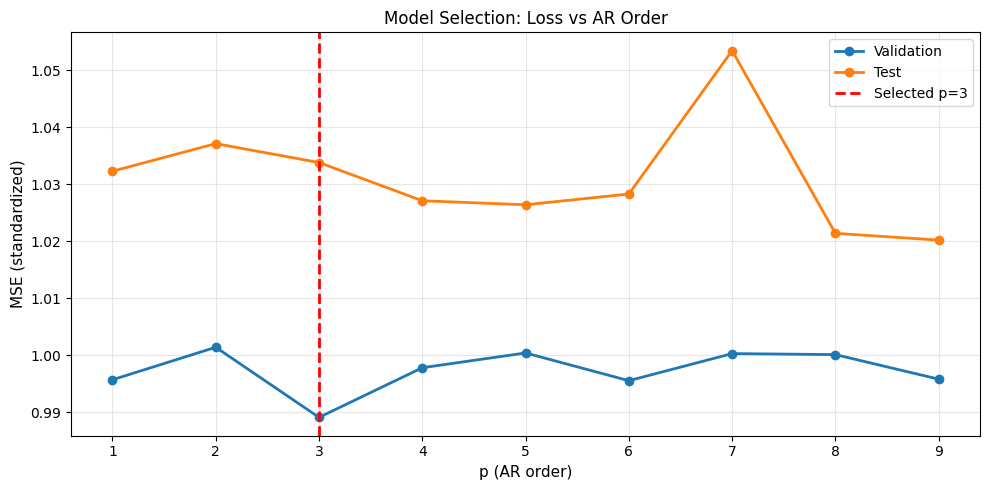

In [ ]:
# Plot validation and test losses across p values
ps = sorted(results.keys())
val = [results[p]["metrics"]["val_mse_standardized"] for p in ps]
tes = [results[p]["metrics"]["test_mse_standardized"] for p in ps]

plt.figure(figsize=(10, 5))
plt.plot(ps, val, marker="o", linewidth=2, markersize=6, label="Validation")
plt.plot(ps, tes, marker="o", linewidth=2, markersize=6, label="Test")
plt.axvline(best_p, color='red', linestyle='--', linewidth=2, label=f'Selected p={best_p}')
plt.xlabel('p (AR order)', fontsize=11)
plt.ylabel('MSE (standardized)', fontsize=11)
plt.title('Model Selection: Loss vs AR Order', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate best model on test set
best_model   = results[best_p]["model"]
best_predict = results[best_p]["predict_np"]
best_scalers = results[best_p]["scalers"]
best_splits  = results[best_p]["splits"]

X_te = best_splits["X_te"]
y_true = best_splits["y_te"]
t_te = best_splits.get("t_te", None)
y_pred = best_predict(X_te, t_te)

# Compute test MSE
test_mse = np.mean((y_true - y_pred) ** 2)
print(f"\n{'='*60}")
print(f"Test Set Evaluation (p={best_p})")
print(f"{'='*60}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Test RMSE: {np.sqrt(test_mse):.6f}")
print(f"Test samples: {len(y_pred)}")
print(f"Correlation: {np.corrcoef(y_pred, y_true)[0,1]:.4f}")
print(f"{'='*60}\n")


Test Set Evaluation (p=3)
Test MSE: 0.011550
Test RMSE: 0.107472
Test samples: 2000
Correlation: 0.0300



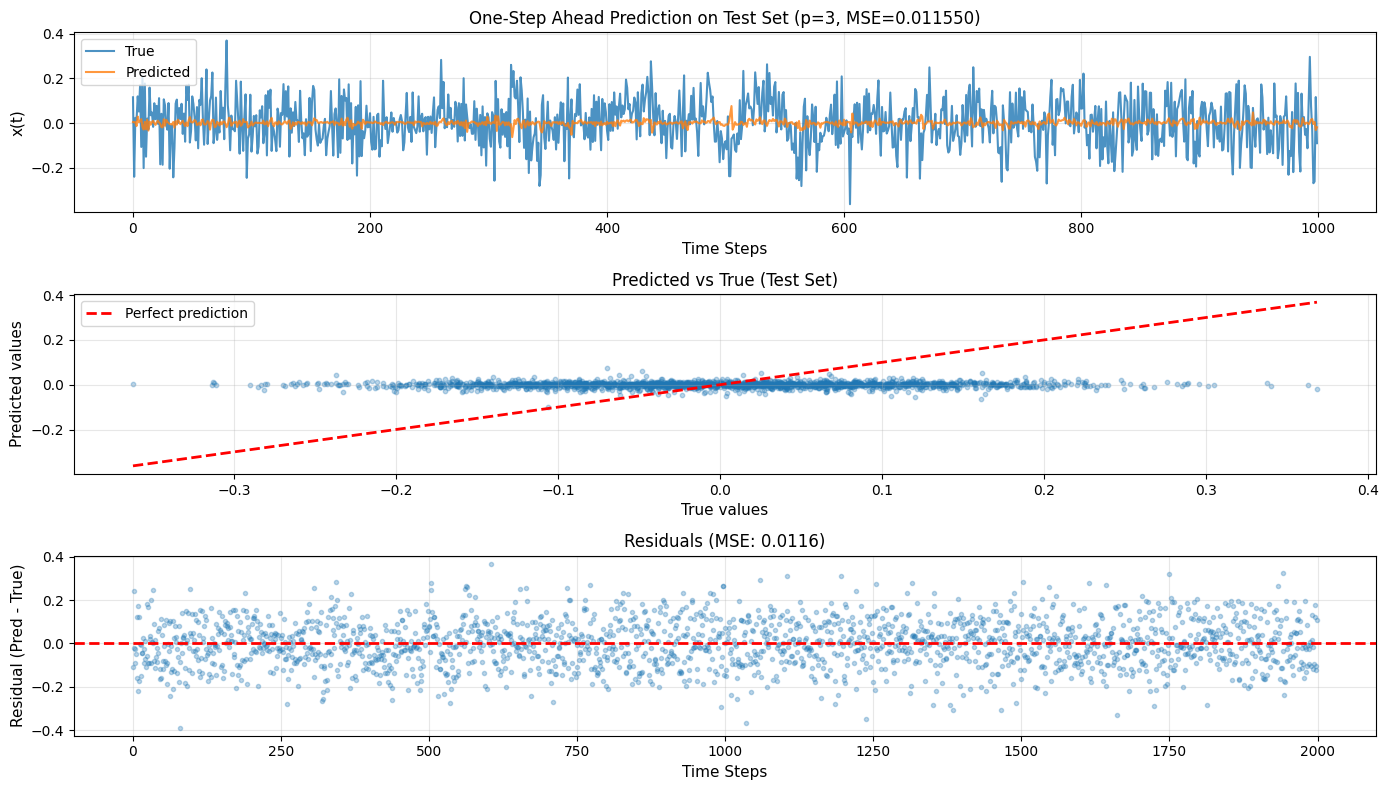

In [ ]:
# Visualize predictions
t_test = np.arange(len(y_true))

plt.figure(figsize=(14, 8))

# Plot 1: time series overlay
plt.subplot(3, 1, 1)
n_plot = min(1000, len(y_true))
plt.plot(t_test[:n_plot], y_true[:n_plot], label='True', linewidth=1.5, alpha=0.8)
plt.plot(t_test[:n_plot], y_pred[:n_plot], label='Predicted', linewidth=1.5, alpha=0.8)
plt.xlabel('Time Steps', fontsize=11)
plt.ylabel('x(t)', fontsize=11)
plt.title(f'One-Step Ahead Prediction on Test Set (p={best_p}, MSE={test_mse:.6f})', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: scatter
plt.subplot(3, 1, 2)
plt.scatter(y_true, y_pred, alpha=0.3, s=10)
mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('True values', fontsize=11)
plt.ylabel('Predicted values', fontsize=11)
plt.title('Predicted vs True (Test Set)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: residuals
residuals = y_pred - y_true
plt.subplot(3, 1, 3)
plt.plot(t_test, residuals, 'o', alpha=0.3, markersize=3)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Time Steps', fontsize=11)
plt.ylabel('Residual (Pred - True)', fontsize=11)
plt.title(f'Residuals (MSE: {np.mean(residuals**2):.4f})', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def estimate_tvar_coefficients(model, scalers, X_raw_batch, device=None):
    """
    Estimate effective time-varying AR coefficients using gradient-based sensitivity.
    
    model: trained TransformerAR
    scalers: dict with X_mean, X_std, y_std
    X_raw_batch: (B, Pmax) raw lags in original units
    returns: (B, Pmax) estimated coefficients for each time point
    """
    if device is None:
        device = next(model.parameters()).device

    X_mean = scalers["X_mean"]
    X_std  = scalers["X_std"]
    y_std  = scalers["y_std"]

    # Standardize inputs
    Xs = (X_raw_batch - X_mean) / X_std
    Xs = Xs.astype(np.float32).reshape(-1, model.Pmax, 1)

    xb = torch.tensor(Xs, device=device, requires_grad=True)
    model.eval()
    yhat_s = model(xb)

    # Compute gradient for each sample
    coeffs = []
    for i in range(len(yhat_s)):
        if xb.grad is not None:
            xb.grad.zero_()
        yhat_s[i].backward(retain_graph=True)
        grad_Xs = xb.grad[i].detach().cpu().numpy().reshape(model.Pmax)
        
        # Chain rule to map to original scale
        eff = (y_std * grad_Xs) * (1.0 / X_std.reshape(-1))
        coeffs.append(eff)
    
    return np.array(coeffs)

In [ ]:
# Extract learned time-varying coefficients
device = "cuda" if torch.cuda.is_available() else "cpu"
learned_coeffs = estimate_tvar_coefficients(best_model, best_scalers, X_te, device)

# Align true coefficients with test data time indices
# The test data corresponds to specific time points in the original signal
p_true = a_true.shape[1]  # True AR order from data generation
Pmax_used = best_p

# Calculate where test data starts in the original time series
# After creating lags with Pmax, we lose the first Pmax samples
# Then we split: 60% train, 20% val, 20% test
N_total = len(x) - best_p  # Total samples after lagging
n_tr = int(0.6 * N_total)
n_va = int(0.2 * N_total)
test_start_idx = best_p + n_tr + n_va  # Account for lag offset + train/val samples

# Extract corresponding true coefficients
a_true_test = a_true[test_start_idx:test_start_idx + len(learned_coeffs), :]

print(f"\nCoefficient Alignment:")
print(f"True p: {p_true}")
print(f"Selected p: {best_p}")
print(f"Test samples: {len(learned_coeffs)}")
print(f"True coefficients shape: {a_true_test.shape}")
print(f"Learned coefficients shape: {learned_coeffs.shape}\n")


Coefficient Alignment:
True p: 4
Selected p: 3
Test samples: 2000
True coefficients shape: (2000, 4)
Learned coefficients shape: (2000, 3)



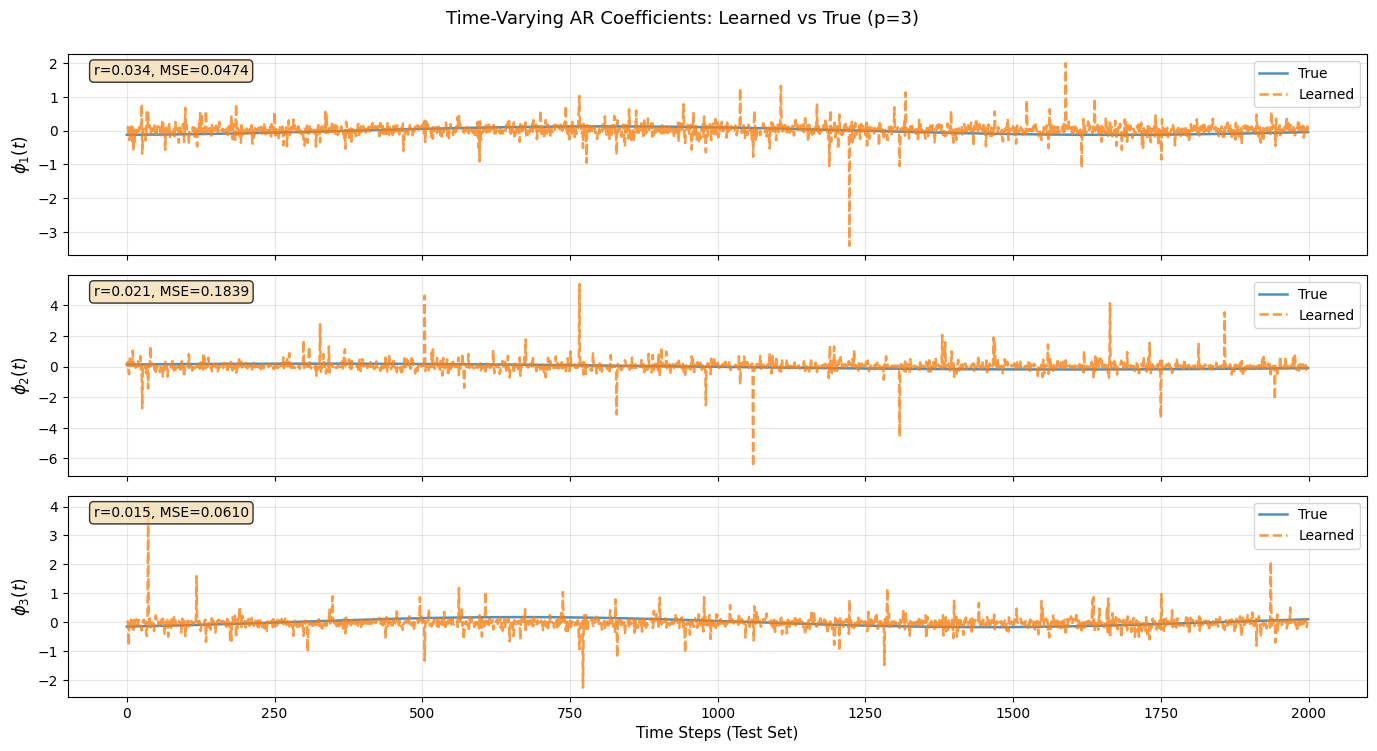


Coefficient Recovery Statistics:
Lag 1: Correlation=0.0343, MSE=0.047392
Lag 2: Correlation=0.0207, MSE=0.183869
Lag 3: Correlation=0.0146, MSE=0.061027



In [ ]:
# Compare learned vs true time-varying coefficients
n_lags_plot = min(best_p, p_true)

fig, axes = plt.subplots(n_lags_plot, 1, figsize=(14, 2.5*n_lags_plot), sharex=True)
if n_lags_plot == 1:
    axes = [axes]

t_test = np.arange(len(learned_coeffs))
n_plot = min(2000, len(learned_coeffs))

for i in range(n_lags_plot):
    # Plot true coefficient
    axes[i].plot(t_test[:n_plot], a_true_test[:n_plot, i], 
                label='True', linewidth=1.8, alpha=0.8, color='C0')
    
    # Plot learned coefficient
    axes[i].plot(t_test[:n_plot], learned_coeffs[:n_plot, i], 
                label='Learned', linewidth=1.8, linestyle='--', alpha=0.8, color='C1')
    
    # Calculate correlation and MSE
    corr = np.corrcoef(learned_coeffs[:, i], a_true_test[:, i])[0, 1]
    mse_coeff = np.mean((learned_coeffs[:, i] - a_true_test[:, i]) ** 2)
    
    axes[i].text(0.02, 0.95, f'r={corr:.3f}, MSE={mse_coeff:.4f}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=10)
    
    axes[i].set_ylabel(f'$\\phi_{{{i+1}}}(t)$', fontsize=12)
    axes[i].legend(loc='upper right', fontsize=10)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Steps (Test Set)', fontsize=11)
plt.suptitle(f'Time-Varying AR Coefficients: Learned vs True (p={best_p})', 
             fontsize=13, y=0.995)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nCoefficient Recovery Statistics:")
print(f"{'='*60}")
for i in range(n_lags_plot):
    corr = np.corrcoef(learned_coeffs[:, i], a_true_test[:, i])[0, 1]
    mse = np.mean((learned_coeffs[:, i] - a_true_test[:, i]) ** 2)
    print(f"Lag {i+1}: Correlation={corr:.4f}, MSE={mse:.6f}")
print(f"{'='*60}\n")